# Graph Basics
This notebook shows how define and evaluate kernels on a simple graph. It also shows how to sample from the corresponding Gaussian process prior.

We use the **JAX** backend here.

In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

In [2]:
import networkx as nx
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as onp
import geometric_kernels.jax # using jax as backend for geometric_kernels
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel
from geometric_kernels.kernels.feature_maps import deterministic_feature_map_compact
from geometric_kernels.sampling import sampler

import matplotlib.pyplot as plt

INFO: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO: Using numpy backend


## Create and Visualize a Graph

In [3]:
nx_graph = nx.star_graph(6)

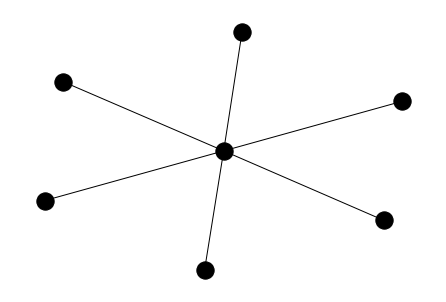

In [4]:
# illustrate graph
nx.draw(nx_graph, node_color = 'black')

The following cell turns the `nx_graph` created above into a GeometricKernels `Graph` space.

The `normalize_laplacian` parameter controls whether to use the eigenvectors
of the *unnormalized Laplacian* or the *symmetric normalized Laplacian* as
features.
You may want to try both `normalize_laplacian=False` and `normalize_laplacian=True` for your task.
The former is the default.

In [5]:
G = Graph(jnp.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)

## Define a GeometricKernels kernel

In [6]:
# create a kernel
kernel = MaternKarhunenLoeveKernel(G, G.num_vertices)

# initialize kernel with reasonable values
params, state = kernel.init_params_and_state()
# The following setting of `nu` coresponds to the heat (RBF) kernel
# for actual Matérn kernels consider finite values of `nu`
params["nu"] = jnp.array([jnp.inf])
# Note: the "reasonable" range of length scales is different for various graphs
params["lengthscale"] = jnp.array([2.])

## Define Feature Map and Obtain Two Samples

In [7]:
feature_map = deterministic_feature_map_compact(G, kernel)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = PRNGKey(1234)
sample_paths = sampler(feature_map, s=2)
# new random state is returned along with the samples
key, samples = sample_paths(jnp.arange(G.num_vertices)[:, None], params, state, key=key)

sample1 = onp.asarray(samples[:, 0])
sample2 = onp.asarray(samples[:, 1])

/home/vabor112/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4404: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


## Visualize Kernel, Prior Variance and Two Samples

**Important:** the following cell **normalizes** the variances, kernel values and samples, **as if they correspond to a normalized kernel**.

We say that the kernel is normalized if the average of k(\*, \*), with \* running over all nodes, equals 1.
**By default, the kernel may fail to be normalized.**

In [8]:
highlighted_node = 1 # choosing a fixed node for kernel visualization
node_ids = jnp.arange(G.num_vertices)[:, None]
# Get prior variances k(*, *) for * in nodes:
variance = onp.asarray(kernel.K_diag(params, state, node_ids))
# Get kernel values k(highlighted_node, *) for * in nodes:
values = onp.asarray(kernel.K(params, state, jnp.array([[highlighted_node]]),
                              node_ids)).flatten()

# Normalize everything
mean_variance = jnp.mean(variance)
variance /= mean_variance
values   /= mean_variance
sample1  /= jnp.sqrt(mean_variance)
sample2  /= jnp.sqrt(mean_variance)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(highlighted_node, *)` where `*` goes through all nodes and `highlighted_node` has red outline. 

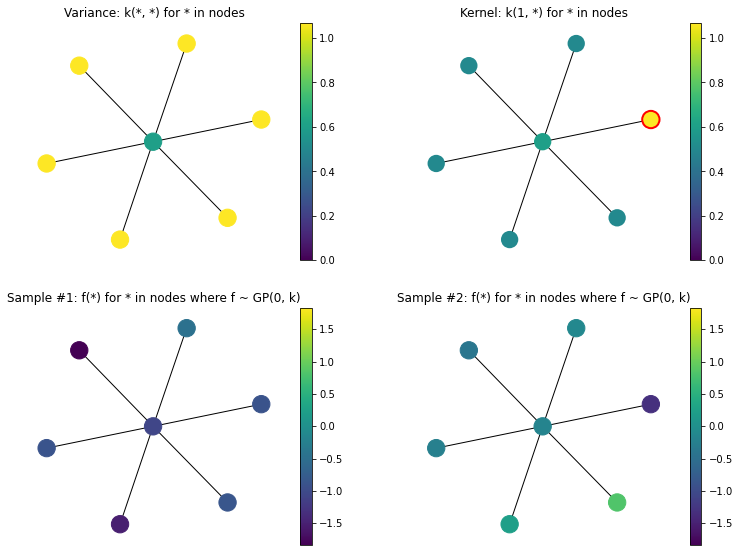

In [9]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
var_vmin = min(0.0, values.min())
var_vmax = max(1.0, variance.max())
val_vmin, val_vmax = var_vmin, var_vmax
val_smax = max(1., val_vmax, onp.abs(sample1.max()), onp.abs(sample2.max()),
               onp.abs(sample1.min()), onp.abs(sample2.min()))
val_smin = -val_smax


# Red outline for the highlighted_node:
edgecolors = [(0, 0, 0, 0)]*G.num_vertices
edgecolors[highlighted_node] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': nx.spring_layout(nx_graph)}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=variance,
        vmin=var_vmin, vmax=var_vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=var_vmin, vmax=var_vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: k(*, *) for * in nodes')

# Plot kernel values
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values,
        vmin=val_vmin, vmax=val_vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=val_vmin, vmax=val_vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: k(%d, *) for * in nodes' % highlighted_node)

# Plot sample #1 values
nx.draw(nx_graph, ax=ax3, cmap=cmap, node_color=sample1,
        vmin=val_smin, vmax=val_smax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=val_smin, vmax=val_smax))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Sample #1: f(*) for * in nodes where f ~ GP(0, k)')

# Plot sample #2 values
nx.draw(nx_graph, ax=ax4, cmap=cmap, node_color=sample2,
        vmin=val_smin, vmax=val_smax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=val_smin, vmax=val_smax))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Sample #2: f(*) for * in nodes where f ~ GP(0, k)')

plt.show()

## A Note on Prior Variance

Note that the **variance changes from node to node** on this graph.

For example, for the **unnormalized Laplacian**, the variance is related to the *return time of a random walk*: how many steps, on average, does it take a particle
randomly walking over the graph and starting in node x to return back to node x.
For the center node, the return time is always equal to 2.
For other nodes, it is always higher.
Hence the variance in the center is *lower* than in the other nodes.

For the **symmetric normalized Laplacian** the sitation is different.

This argument is inspired by [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2010.15538.pdf)
See this [Jupyter notebook](https://github.com/spbu-math-cs/Graph-Gaussian-Processes/blob/main/examples/graph_variance.ipynb) for more examples of how variance differs for different graphs.

In [10]:
print('Variance in the center node is %0.2f,' % variance[0],
      'variance in the side nodes is %0.2f.' % variance[1],
      'The average variance is %0.2f.' % onp.mean(variance))

Variance in the center node is 0.60, variance in the side nodes is 1.07. The average variance is 1.00.
